# Assignment 3

# Variational Dropout Sparsifies Deep Neural Networks

The Variational Dropout (https://arxiv.org/abs/1506.02557) provides a Bayesian interpretation of conventional dropout procedure. Later it was shown that Variational Dropout can be used for model sparsification (Sparse VD), the effect can be achieved by via optimization of variational lower bound wrt individual dropout rates for every weight of the model (https://arxiv.org/abs/1701.05369).

#### Sparse VD

Sparse VD model optimizes VLB $\mathcal{L}(\phi)$ with respect to parameters $\phi$ of a variational approximation $q_\phi(w)$:

$$\mathcal{L}(\phi) =  L_\mathcal{D}(\phi) - D_{KL}(q_\phi(w)\,\|\,p(w)) \to\max_{\phi\in\Phi}$$
$$L_\mathcal{D}(\phi) = \sum_{n=1}^N \mathrm{E}_{q_\phi(w)}[\log p(y_n\,|\,x_n, w)],$$

where $p(w)$ is the log-uniform prior distibution, the variational approxinmation $q_\phi(w)$ is a fullly factorized gaussian, the likelihood $p(y\,|\,x, w)$ is defined by a neuralnework with parametrs $w$. The optimization is performed by stohasic optimization methods e.g., Adam, etc.

For more convenience computing, the KL divergence is approximated as follows:
\begin{equation}
\begin{gathered}
    -D_{KL}(q(w_{ij}\,|\,\theta_{ij}, \alpha_{ij})\,\|\,p(w_{ij})) \approx
    \\
    \approx k_1\sigma(k_2 + k_3\log \alpha_{ij})) - 0.5\log(1+\alpha_{ij}^{-1}) + \mathrm{C}
    \label{eq:KL}\\
    k_1=0.63576~~~~~k_2=1.87320~~~~~k_3=1.48695
\end{gathered}
\end{equation}

**Note:** In the paper two parametrizations of q are used. The fist one is $\phi_i=\{\mu_{i}, \sigma_i\}$ that means $w_{ij} \sim N(w_{ij} | \mu_{ij}, \sigma^2_{ij})$ and the second one is $\phi_{ij}=\{\mu_{ij}, \alpha_{ij}\}$ that means $w_{ij} \sim N(w_{ij} | \mu_{ij}, \alpha_{ij}\mu^2_{ij})$. This two parametrization are connected as $\sigma^2_{ij} = \alpha_{ij}\mu^2_{ij}$. Do not be confused.


# In this assignment:
1. Implementation of fully-connected Sparse VD layer
2. Training Lenet-300-100 on MNIST dataset
3. Optional Research Assignment

Additional information:
- If you have a problem with importing logger, download logger.py and file to the same folder and run a notebook from it
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib), tabulate
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 3, 2018"

In [1]:
import math
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from logger import Logger
from torch.nn import Parameter
from torch.autograd import Variable
from torchvision import datasets, transforms

## Implementation of  Sparse VD layer

In [2]:
class LinearSVDO(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearSVDO, self).__init__()
        """
            in_features: int, a number of input features
            out_features: int, a number of neurons
            threshold: float, a threshold for clipping weights
        """
        
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold
        self.epsilon = 1e-8

        # torch.nn.parameter.Parameter of size out_features x in_features - No.
        self.mu = torch.nn.Parameter(torch.zeros([in_features, out_features]))
        # torch.nn.parameter.Parameter of size out_features x in_features - No.
        self.log_sigma = torch.nn.Parameter(torch.ones([in_features, out_features]))
        # torch.nn.parameter.Parameter of size 1 x out_features
        self.bias = torch.nn.Parameter(torch.zeros([1, out_features]))
        self.reset_parameters()
        
    def reset_parameters(self):
        self.bias.data.zero_()
        self.mu.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)     
        
    def calculate_log_alpha(self):
        log_alpha = 2 * self.log_sigma - 2 * torch.log(torch.abs(self.mu) + self.epsilon)
        # clipping for a numerical stability
        log_alpha = torch.clamp(log_alpha, -10, 10)
        return log_alpha
        
    def forward(self, x):      
        # x is a torch.Tensor of shape (?number_of_objects, in_features)
        # log_alpha is a torch.Tensor of shape (out_features, in_features)
        self.log_alpha = self.calculate_log_alpha()
        
        if self.training:
            # lrt_mean is a torch.Tensor of shape (x.shape[0], out_features)
            # compute mean activation using LRT
            lrt_mean = torch.matmul(x, self.mu)
            
            # lrt_std is a torch.Tensor of shape (x.shape[0], out_features)
            # compute std of activations unsig lrt
            # do not forget use torch.sqrt(x + 1e-8) instead of torch.sqrt(x)
            lrt_var = torch.matmul(x ** 2, torch.exp(2 * self.log_sigma))
            lrt_std = torch.sqrt(lrt_var + self.epsilon)
                      
            # eps is a torch.Tensor of shape (x.shape[0], out_features)
            # sample of noise for reparametrization
            eps = torch.randn(lrt_mean.shape)
            return lrt_mean + eps * lrt_std + self.bias # sample of activation
        
        W = self.mu * (self.log_alpha <= self.threshold).type(torch.float)
        out = torch.matmul(x, W) + self.bias # compute the output of the layer
        # use weighs W = Eq = self.mu
        # clip all weight with log_alpha > threshold
        return out
        
    def kl_reg(self):
        k1, k2, k3 = torch.Tensor([0.63576]), torch.Tensor([1.8732]), torch.Tensor([1.48695])
        # kl is a scalar torch.Tensor 

        # eval KL using the approximation
        kl = -k1 * torch.sigmoid(k2 + k3 * self.log_alpha) - 0.5 * nn.functional.logsigmoid(self.log_alpha)
        return kl.sum()

## Define LeNet-300-100

In [3]:
class Net(nn.Module):
    def __init__(self, threshold):
        super(Net, self).__init__()
        self.fc1 = LinearSVDO(28 * 28, 300, threshold)
        self.fc2 = LinearSVDO(300,  100, threshold)
        self.fc3 = LinearSVDO(100,  10, threshold)
        self.threshold=threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

## Function for loading MNIST

In [4]:
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## Create SGVLB loss

In [5]:
def one_hot(batch, depth):
    ones = torch.sparse.torch.eye(depth)
    return ones.index_select(0, batch)

class SGVLB(nn.Module):
    def __init__(self, net, train_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size # int, the len of dataset
        self.net = net # nn.Module

    def reg(self):
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        return kl

    def loss(self, input, target):
        one_hot_target = one_hot(target, input.shape[1])
        log_likelihood = (one_hot_target * input)
        #log_likelihood = input[:, target] # shape: [n_objects, n_classes]
        return -log_likelihood.sum() * self.train_size / input.shape[0]
        
    def forward(self, input, target, kl_weight=1.0):
        assert not target.requires_grad
        loss = self.loss(input, target)
        reg = self.reg()
        return loss + kl_weight * reg

## Define the model

In [6]:
epochs = 100

model = Net(threshold=3)
optimizer = torch.optim.Adam(model.parameters())# optimizer
# decrease learning rate by torch.optim.lr_scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

train_loader, test_loader = get_mnist(batch_size=100)
sgvlb = SGVLB(model, len(train_loader.dataset))

## Train the model

In [7]:
kl_weight = 0.02

for epoch in range(1, epochs + 1):
    scheduler.step()
    model.train()
    train_loss, train_acc = 0, 0 
    kl_weight = min(kl_weight + 0.02, 1)
    logger.add_scalar(epoch, 'kl', kl_weight)
    logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28 * 28)
        optimizer.zero_grad()
        
        output = model(data)        
        pred = output.data.max(1)[1] 
        loss = sgvlb(output, target, kl_weight)
        
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss) 
        train_acc += np.sum(pred.numpy() == target.data.numpy())

    logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)
    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.view(-1, 28 * 28)
        output = model(data)
        test_loss += float(sgvlb(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.numpy() == target.data.numpy())
        
    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)
    
    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.numpy() > model.threshold).mean())
            
    logger.iter_info()

/Users/icecream/code/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


  epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2
-------  ----  -------  --------  --------  ---------  --------  ------  ------  ------
      1  0.04  1.0e-03   2.0e+02      91.2    7.4e+01      96.0   0.354   0.131     0.0
      2  0.06  1.0e-03   4.0e+01      96.4    1.6e+01      97.0   0.499   0.231     0.0
      3  0.08  1.0e-03  -2.0e+01      97.4   -3.1e+01      97.5   0.578   0.326     0.1
      4  0.10  1.0e-03  -6.6e+01      97.6   -7.3e+01      97.6   0.639   0.404     0.1
      5  0.12  1.0e-03  -1.1e+02      97.9   -1.0e+02      97.2   0.699   0.438     0.1
      6  0.14  9.9e-04  -1.5e+02      98.0   -1.5e+02      97.6   0.740   0.480     0.1
      7  0.16  9.9e-04  -1.9e+02      98.1   -1.8e+02      97.7   0.776   0.530     0.1
      8  0.18  9.9e-04  -2.2e+02      98.2   -2.2e+02      98.0   0.806   0.548     0.1
      9  0.20  9.8e-04  -2.6e+02      98.3   -2.6e+02      98.0   0.824   0.589     0.1
     10  0.22  9.8e-04  -2.9e+02

     93     1  1.6e-05  -1.6e+03      98.4   -1.6e+03      98.5   0.974   0.957     0.7
     94     1  1.2e-05  -1.6e+03      98.6   -1.6e+03      98.5   0.974   0.957     0.7
     95     1  8.9e-06  -1.6e+03      98.5   -1.6e+03      98.5   0.974   0.957     0.7
     96     1  6.2e-06  -1.6e+03      98.5   -1.6e+03      98.5   0.974   0.957     0.7
     97     1  3.9e-06  -1.6e+03      98.5   -1.6e+03      98.5   0.974   0.957     0.7
     98     1  2.2e-06  -1.6e+03      98.5   -1.6e+03      98.5   0.974   0.957     0.7
     99     1  9.9e-07  -1.6e+03      98.4   -1.6e+03      98.5   0.974   0.957     0.7
    100     1  2.5e-07  -1.6e+03      98.5   -1.6e+03      98.5   0.974   0.957     0.7


In [8]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.data.numpy() < model.threshold).sum()
    all_w += c.log_alpha.data.numpy().size

# compression_ratio shold be > 30
compression_ratio = all_w/kep_w
print('compression_ratio =', compression_ratio)
assert compression_ratio > 30

compression_ratio = 34.71117485982527


## Disk space

In [21]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].mu.transpose(1, 0).data.numpy()
LA = list(model.children())[0].log_alpha.transpose(1, 0).data.numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [22]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [23]:
!ls -lah | grep .npz 

-rw-r--r--   1 icecream  LD\Domain Users   825K Apr 11 00:53 M_w.npz
-rw-r--r--   1 icecream  LD\Domain Users    30K Apr 11 00:53 Mcoo_w.npz
-rw-r--r--   1 icecream  LD\Domain Users    29K Apr 11 00:53 Mcsc_w.npz
-rw-r--r--   1 icecream  LD\Domain Users    29K Apr 11 00:53 Mcsr_w.npz


## Visualization

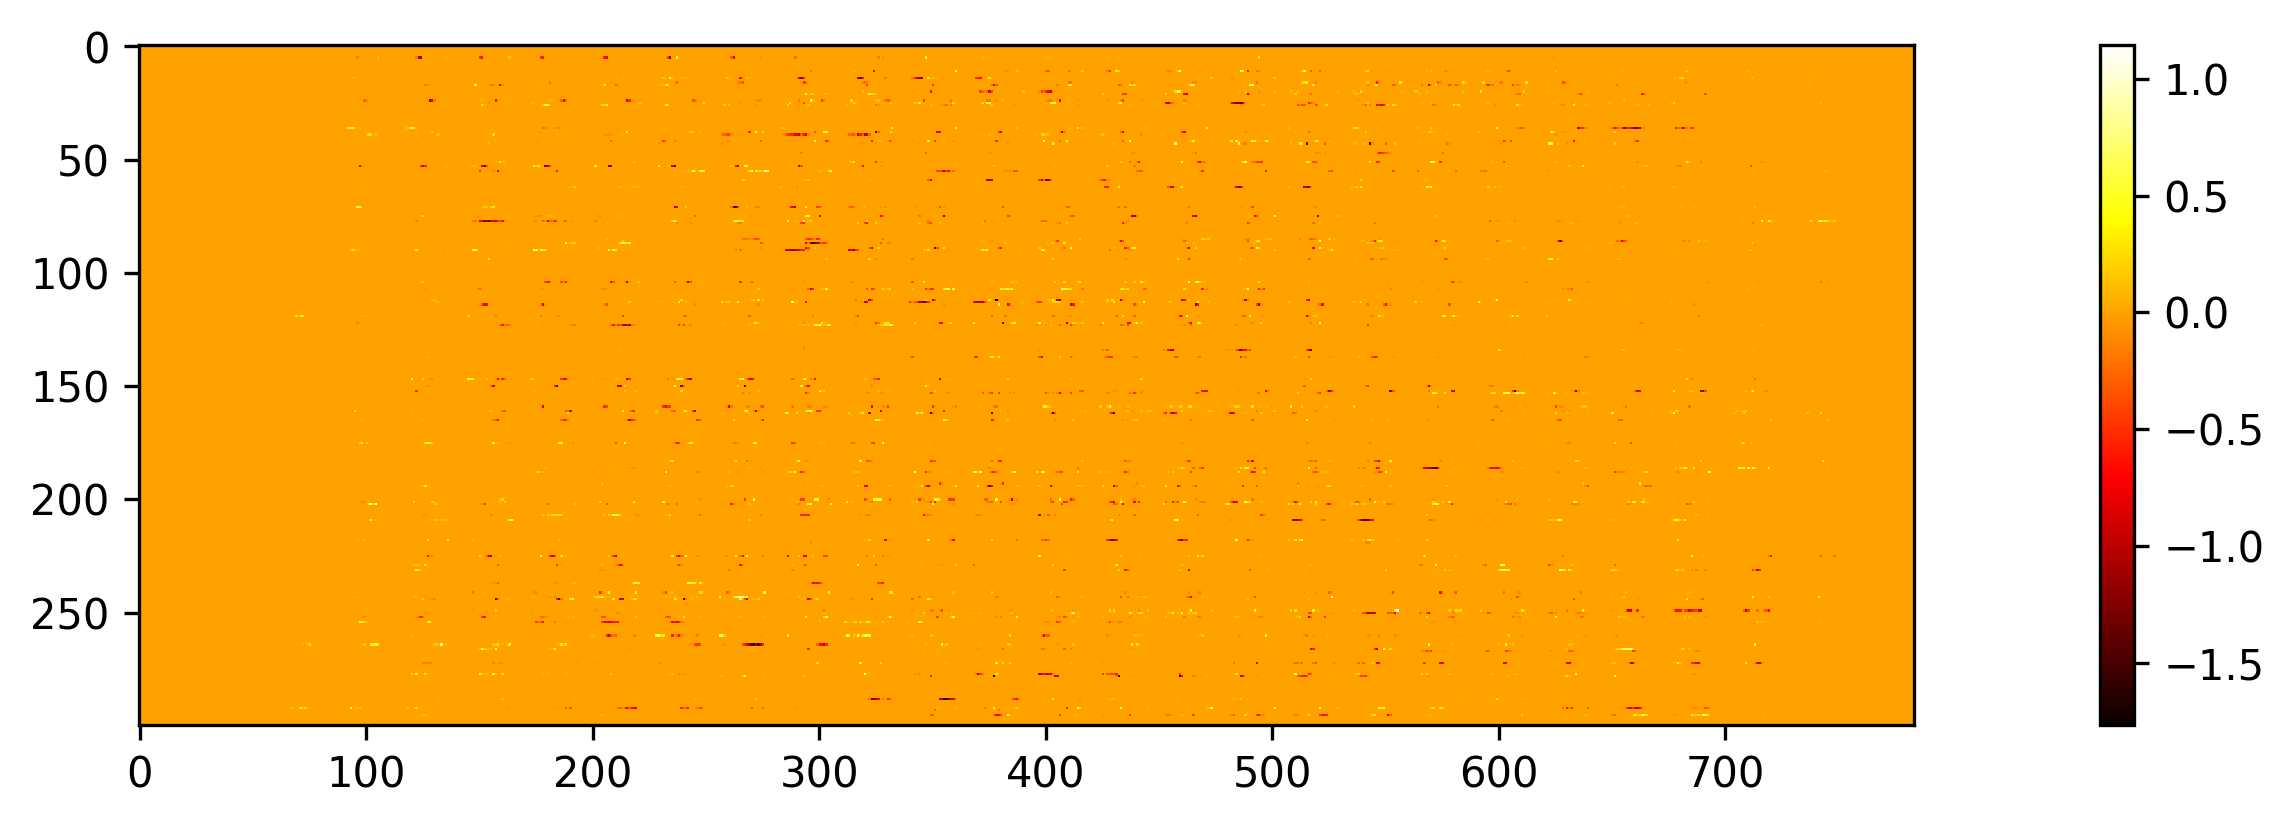

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 3
rcParams['figure.dpi'] = 300


log_alpha = (model.fc1.log_alpha.transpose(1, 0).detach().numpy() < 3).astype(np.float)
W = model.fc1.mu.transpose(1, 0).detach().numpy()

plt.imshow(log_alpha * W, cmap='hot', interpolation=None)
plt.colorbar()

(-0.5, 419.5, 419.5, -0.5)

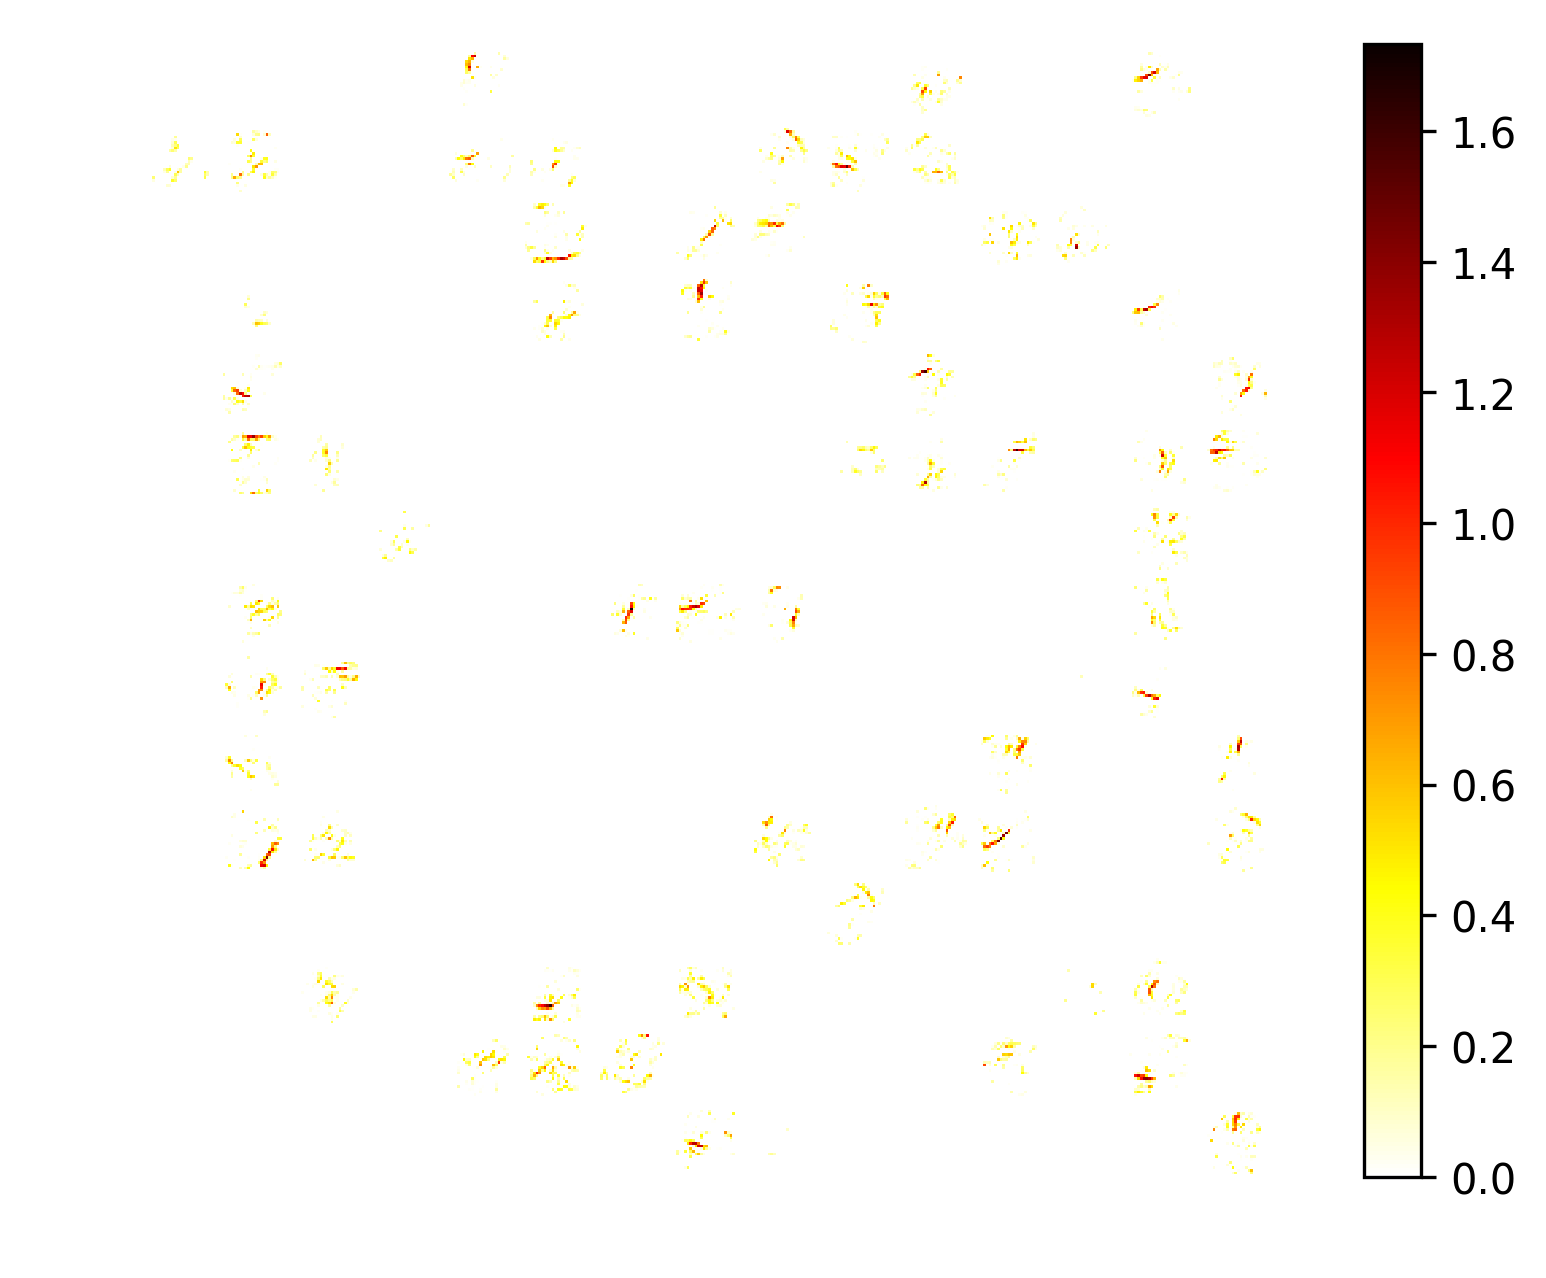

In [27]:
s = 0
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 5

z = np.zeros((28 * 15, 28 * 15))

for i in range(15):
    for j in range(15):
        s += 1
        z[slice(i * 28, (i + 1) * 28), slice(j * 28, (j + 1) * 28)] = np.abs((log_alpha * W)[s].reshape(28, 28))
        
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')

# Optional Research Assignment (up to 2 points)

1. Study the model: 
    - How sparsity and accuracy depend on maximum of KL-multiplier (kl_weight)?
    - How quality depends on the initialization of log_sigma (log_sigma)?
    - Study the KL approximation: what if we use the reparametrization trick to obtain an unbiased MC estimate of KL?
2. Compression:
    - What can we do to obtain better compression results with small quality degradation?
    - Propose and eval several options.
3. Study the Local reparametrization trick: 
    - Does it really accelerate convergence?
    - Does variance of gradient decrease?
    
You can do one out of three parts. You need to provide evidence for results e.g., plots, etc.